# Import all required libraries

In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

# Load pre-trained image classifier from Tf-hub

In [2]:
model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v1 (KerasLayer)   (None, 1001)              6633209   
                                                                 
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


# Load labels from [this url](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt)

In [3]:
def load_imagenet_labels(file_path):
  labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
  with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
  return np.array(labels)

In [4]:
imagenet_labels = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

# Load and show images

In [5]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

In [6]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

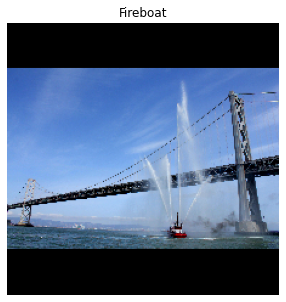

In [7]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1, 2, n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()

# Return the top 5 predictions for the images

In [8]:
def top_k_predictions(img, k=5):
  image_batch = tf.expand_dims(img, 0)
  predictions = model(image_batch)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = imagenet_labels[tuple(top_idxs)]
  return top_labels, top_probs[0]

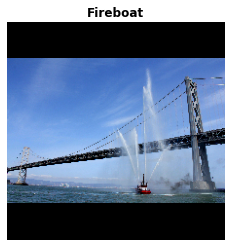

fireboat: 32.6%
pier: 12.7%
suspension bridge: 5.7%
crane: 4.6%
schooner: 2.9%


In [9]:
for (name, img_tensor) in img_name_tensors.items():
  plt.imshow(img_tensor)
  plt.title(name, fontweight='bold')
  plt.axis('off')
  plt.show()

  pred_label, pred_prob = top_k_predictions(img_tensor)
  for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

## Pick a baseline

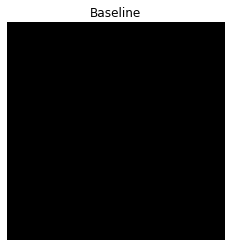

In [10]:
baseline = tf.zeros(shape=(224,224,3))
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

# Interpolate image

In [11]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [12]:
def interpolate_images(baseline,
                       image,
                       alphas,
                       degree):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  pow(alphas_x, degree) * delta
  return images

In [13]:
interpolated_images = []

# Must be an integer greater or equal than 0
max_degree = 2

for degree in range(1, max_degree + 1):
    interpolated_images.append(interpolate_images(
        baseline=baseline,
        image=img_name_tensors['Fireboat'],
        alphas=alphas,
        degree=degree))

interpolated_images = tf.stack(interpolated_images)

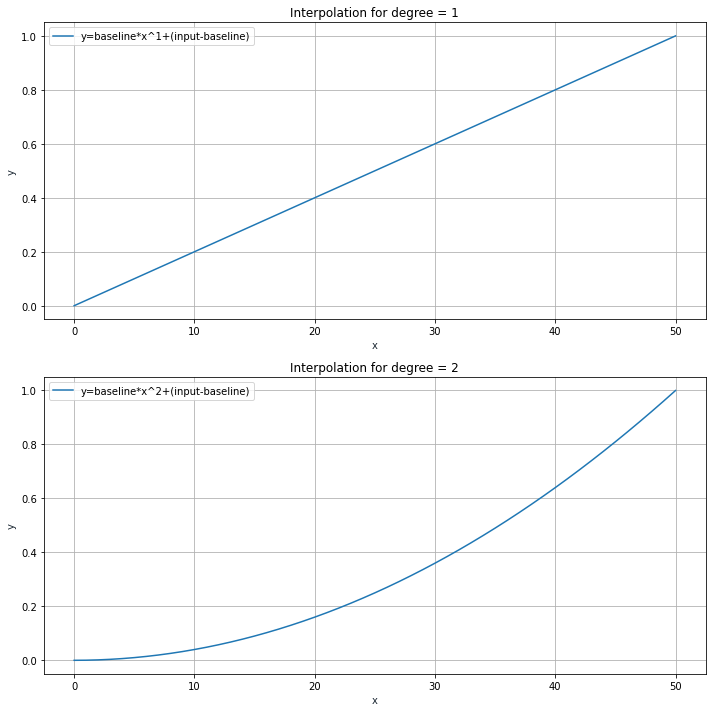

In [17]:
x = np.arange(0, m_steps + 1, 1)
number_of_graphs = int(tf.shape(interpolated_images)[0])
fig, axs = plt.subplots(number_of_graphs, figsize=(10,5*degree))
for degree in range(1, number_of_graphs + 1):
    y = interpolated_images[degree-1,0:m_steps+1,100,100,0] / interpolated_images[degree-1,m_steps,100,100,0]
    axs[degree-1].plot(x, y, label='y=baseline*x^' + str(degree) + '+(input-baseline)')
    axs[degree-1].set_title('Interpolation for degree = ' + str(degree))
    axs[degree-1].grid()
    axs[degree-1].legend(loc='upper left')
    axs[degree-1].set_ylabel('y', color='#1C2833')
    axs[degree-1].set_xlabel('x', color='#1C2833')
plt.tight_layout();
plt.show();

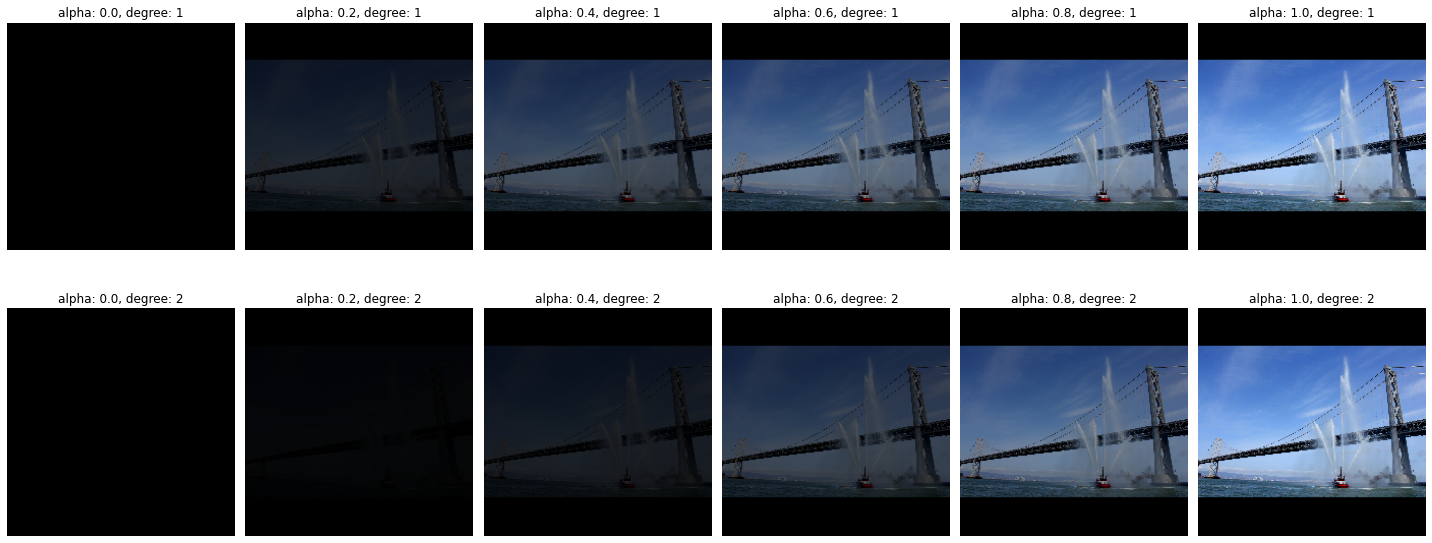

In [18]:
fig = plt.figure(figsize=(20, 20))

i = 0
for degree in range(1, max_degree + 1):
    for alpha, image in zip(alphas[0::10], interpolated_images[degree-1,0::10]):
      i += 1
      plt.subplot(5, len(alphas[0::10]), i)
      plt.title(f'alpha: {alpha:.1f}, degree: {degree}')
      plt.imshow(image)
      plt.axis('off')

plt.tight_layout();

# Compute gradients

In [40]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

In [127]:
def integral_approximation(gradients, degree):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    size = tf.shape(grads)[0]
    summ = 0
    counter = 0
    denominator = tf.cast(pow(size, degree), tf.float32)
    for grad in grads:
        counter=counter+1
        summ = summ + grad * pow(counter, degree - 1)
    
    integrated_gradients = tf.cast(degree, tf.float32) * tf.cast(summ, tf.float32) / denominator
    return integrated_gradients

In [125]:
path_gradients = compute_gradients(
    images=interpolated_images[0],
    target_class_idx=555)
ig = integral_approximation(
    gradients=path_gradients, degree=1)

In [126]:
tf.sqrt(tf.reduce_sum(tf.square(ig))).numpy()

3.109021

In [22]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx, polynomial_degree):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch,
                                                       degree = polynomial_degree)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [42]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         polynomial_degree,
                         m_steps=50,
                         batch_size=32):
    # Generate alphas.
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

    # Collect gradients.    
    gradient_batches = []

    # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]

        gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx, polynomial_degree)
        gradient_batches.append(gradient_batch)

    # Stack path gradients together row-wise into single tensor.
    total_gradients = tf.stack(gradient_batch)

    # Integral approximation through averaging gradients.
    avg_gradients = integral_approximation(gradients=total_gradients, degree=polynomial_degree)

    # Scale integrated gradients with respect to input.
    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients

In [135]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          max_polynomial_degree,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):
    
    attribution_mask = []
    for degree in range(1, max_polynomial_degree + 1):
        attributions = integrated_gradients(baseline=baseline,
                                           image=img_name_tensors['Fireboat'],
                                           polynomial_degree=degree,
                                           target_class_idx=target_class_idx,
                                           m_steps=m_steps)
        # Sum of the attributions across color channels for visualization.
        # The attribution mask shape is a grayscale image with height and width
        # equal to the original image.
        attribution_mask.append(tf.reduce_sum(tf.math.abs(attributions), axis=-1))
    attribution_mask = tf.stack(attribution_mask)    

    fig, axs = plt.subplots(nrows=1 + max_polynomial_degree, ncols=2, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')
    
    for degree in range(1, max_polynomial_degree + 1):

        axs[degree, 0].set_title(f'Attribution mask, degree: {degree}')
        axs[degree, 0].imshow(attribution_mask[degree-1], cmap=cmap)
        axs[degree, 0].axis('off')

        axs[degree, 1].set_title(f'Overlay, degree: {degree}')
        axs[degree, 1].imshow(attribution_mask[degree-1], cmap=cmap)
        axs[degree, 1].imshow(image, alpha=overlay_alpha)
        axs[degree, 1].axis('off')

    plt.tight_layout()
    return fig, attribution_mask

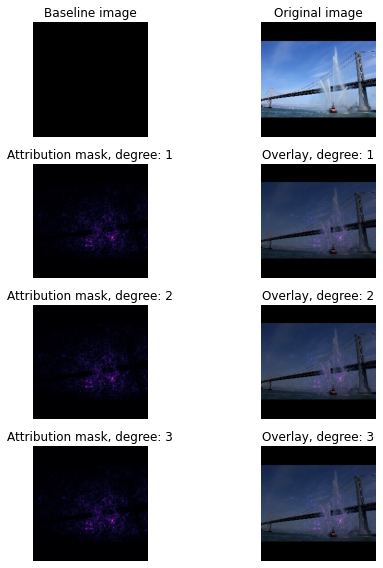

In [140]:
max_polynomial_degree_graph=3
_, attribution_masks = plot_img_attributions(image=img_name_tensors['Fireboat'],
                          baseline=baseline,
                          max_polynomial_degree=max_polynomial_degree_graph,
                          target_class_idx=555,
                          m_steps=500,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

In [141]:
norm_degree_one = tf.sqrt(tf.reduce_sum(tf.square(attribution_masks[0]))).numpy()

for degree in range(1, max_polynomial_degree_graph + 1):
    norm = tf.sqrt(tf.reduce_sum(tf.square(attribution_masks[degree-1]))).numpy()
    percentage = abs((norm_degree_one - norm) / norm_degree_one) * 100
    print(f'The norm for the degree number {degree} is {norm}, whereas the percentage difference is {percentage:.3f} %')

The norm for the degree number 1 is 3.727870464324951, whereas the percentage difference is 0.000 %
The norm for the degree number 2 is 3.890643835067749, whereas the percentage difference is 4.366 %
The norm for the degree number 3 is 3.9742321968078613, whereas the percentage difference is 6.609 %


(Hypothesis) The greater the number of images in the interpolation (m_steps), the closer should the values be from each other.

Currently this affirmation is not holding. 

To do:

1. Check code and math
2. Check whether all picked paths are monotonic (This [paper](https://proceedings.mlr.press/v162/lundstrom22a/lundstrom22a.pdf) states that being monotonic is not present in the formal definition, and thus this "monotonic" feature should be reviewed)